<a href="https://colab.research.google.com/github/Amirhatamian/ML-/blob/main/PERCOLATION_ON_BOOLEAN_NETWORKS.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial import KDTree
import networkx as nx
from tqdm import tqdm
import itertools

def generate_poisson_points(lambda_density, T):
    """
    Simulate a Poisson process to generate points within a square domain.
    """
    N = np.random.poisson(lambda_density * T**2)
    return np.random.uniform(0, T, (N, 2))
#N is number of points is generated

def create_boolean_network(points, r):
    """
    Create a Boolean network using a k-d tree for efficient neighbor search.

    Parameters:
    points (numpy.ndarray): Array of points.
    r (float): Radius for connectivity.

    Returns:
    networkx.Graph: Graph representing the Boolean network.
    """
    tree = KDTree(points)
    pairs = tree.query_pairs(2 * r)
    G = nx.Graph()
    for i, point in enumerate(points):
        G.add_node(i, pos=point)
    G.add_edges_from(pairs)
    return G

<ipython-input-2-049f63f43547>:10: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = plt.cm.get_cmap('tab20', num_components)


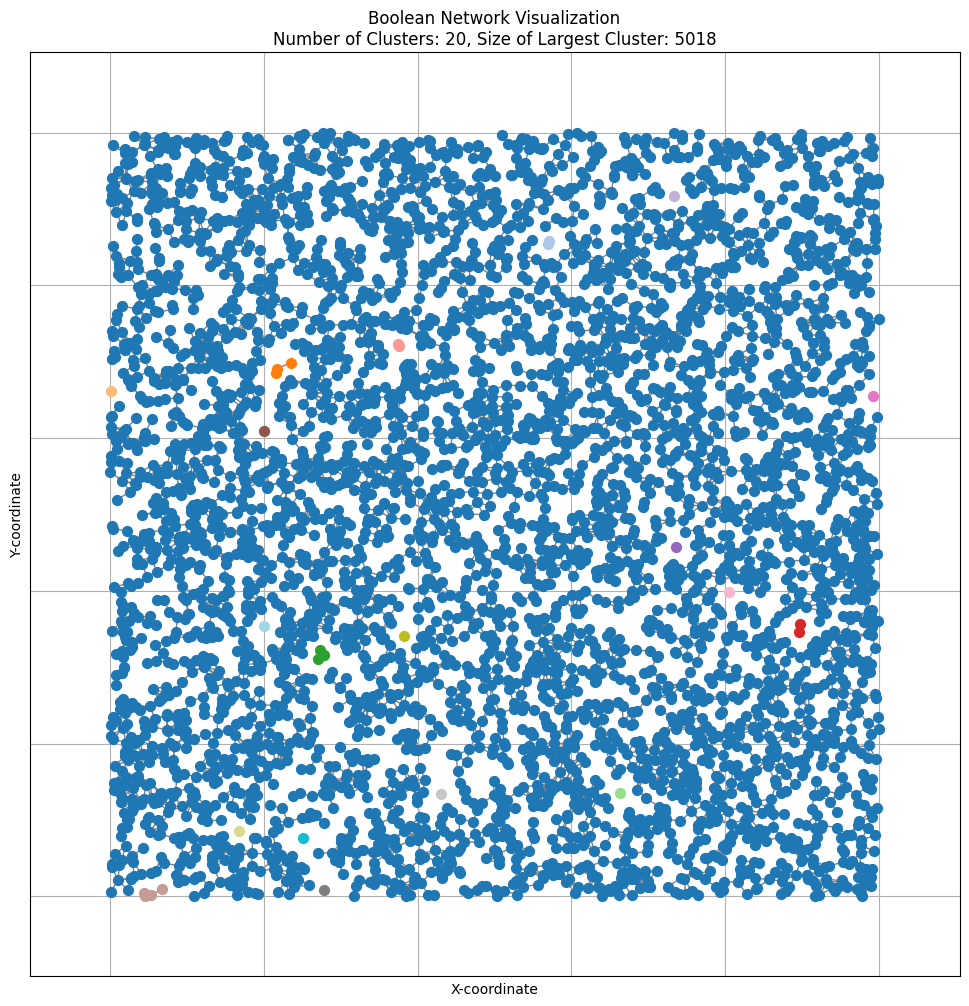

In [2]:
def show_graph(G):
    pos = nx.get_node_attributes(G, 'pos')

    # Identify connected components and color them
    components = list(nx.connected_components(G))
    largest_component_size = max(len(c) for c in components)
    num_components = len(components)

    # Generate unique colors for each component
    colors = plt.cm.get_cmap('tab20', num_components)

    plt.figure(figsize=(12, 12))
    for i, component in enumerate(components):
        nx.draw_networkx_nodes(G, pos, nodelist=component, node_size=50, node_color=[colors(i)])
        nx.draw_networkx_edges(G, pos, edgelist=[(u, v) for u, v in itertools.combinations(component, 2) if G.has_edge(u, v)], edge_color='grey')

    plt.title(f'Boolean Network Visualization\nNumber of Clusters: {num_components}, Size of Largest Cluster: {largest_component_size}')
    plt.xlabel('X-coordinate')
    plt.ylabel('Y-coordinate')
    plt.grid(True)
    plt.show()

    # Example usage
lambda_density = 0.5  # Density of the Poisson process
T = 100               # Size of the square domain
r = 1                 # Radius for connectivity

# Generate points
points = generate_poisson_points(lambda_density, T)

# Create the Boolean network
G = create_boolean_network(points, r)

# Visualize the graph
show_graph(G)

In [3]:
def bfs_largest_cluster(G):
    """
    Use BFS to find the largest cluster in the network.
    """
    largest_cluster_size = 0
    visited = [False] * len(G.nodes)
    for node in G.nodes:
        if not visited[node]:
            size = 0
            queue = [node]
            while queue:
                current = queue.pop(0)
                if not visited[current]:
                    visited[current] = True
                    size += 1
                    queue.extend(n for n in G.neighbors(current) if not visited[n])
            largest_cluster_size = max(largest_cluster_size, size)
    return largest_cluster_size

def simulate_networks(lambda_density, T, r, M):
    """
    Simulate multiple networks to compute the empirical average size of the largest cluster.
    """
    cluster_sizes = []
    for _ in tqdm(range(M), desc=f'Simulating λ={lambda_density:.3f}'):
        points = generate_poisson_points(lambda_density, T)
        G = create_boolean_network(points, r)
        cluster_size = bfs_largest_cluster(G)
        cluster_sizes.append(cluster_size)
    return np.mean(cluster_sizes)


Simulating λ=0.718: 100%|██████████| 50/50 [00:40<00:00,  1.24it/s]


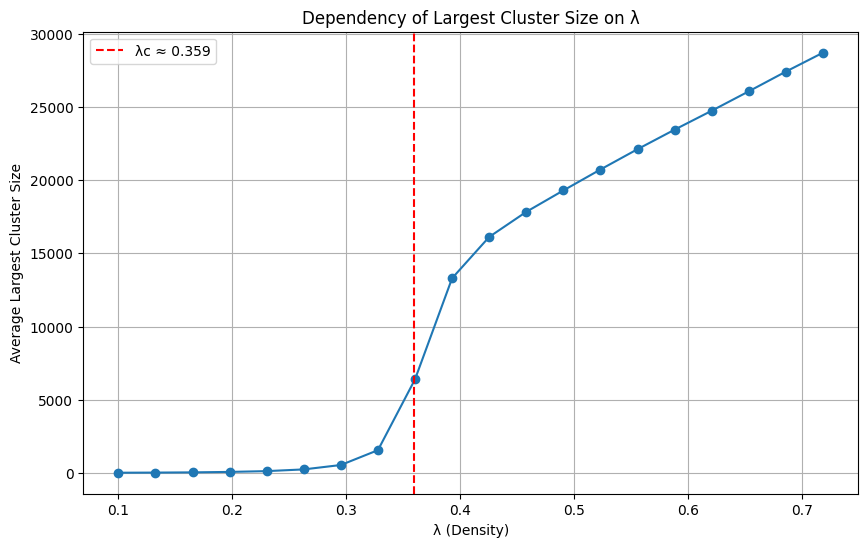

In [6]:
def plot_results(lambdas, cluster_sizes, lambda_c):
    """
    Plot the dependency of the largest cluster size on λ.
    """
    plt.figure(figsize=(10, 6))
    plt.plot(lambdas, cluster_sizes, marker='o')
    plt.axvline(x=lambda_c, color='r', linestyle='--', label=f'λc ≈ {lambda_c:.3f}')
    plt.xlabel('λ (Density)')
    plt.ylabel('Average Largest Cluster Size')
    plt.title('Dependency of Largest Cluster Size on λ')
    plt.legend()
    plt.grid(True)
    plt.show()

def main():
    T = 200  # Size of the square domain
    r = 1    # Connectivity radius
    M = 50  # Number of simulations
    lambda_c = 4.512 / (4 * np.pi)  # Percolation threshold
    lambdas = np.linspace(0.1, 2 * lambda_c, 20)
    results = [simulate_networks(ld, T, r, M) for ld in lambdas]
    plot_results(lambdas, results, lambda_c)

if __name__ == "__main__":
    main()